10


<IPython.core.display.Javascript object>


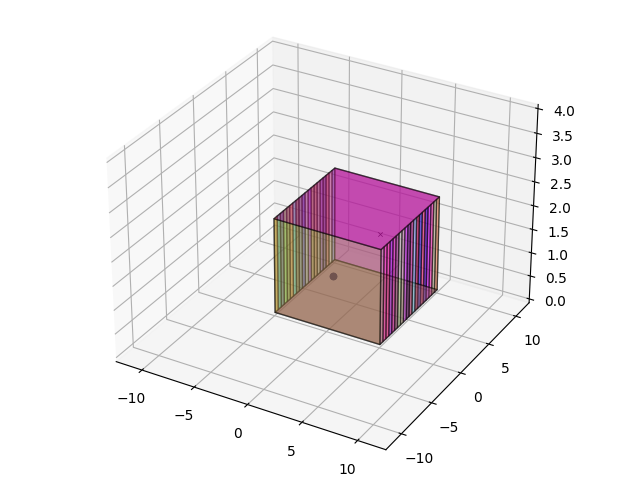

<IPython.core.display.Javascript object>


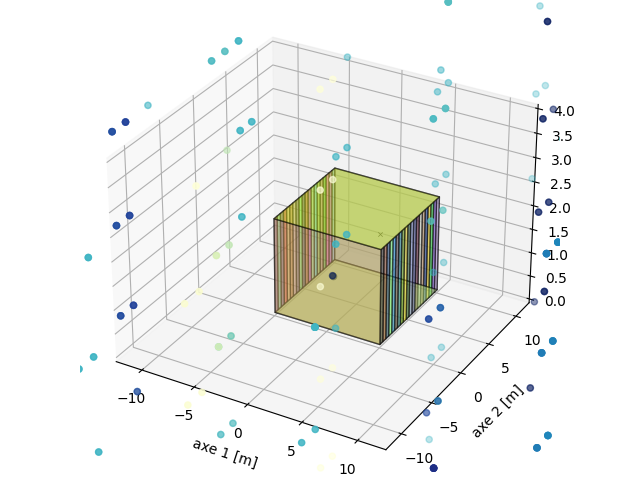

<IPython.core.display.Javascript object>


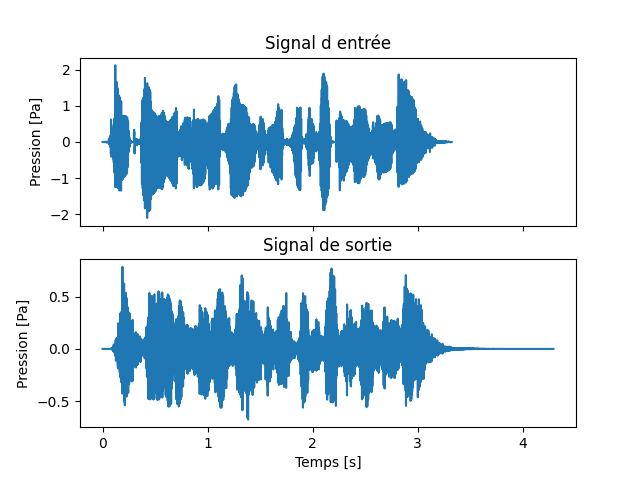

<IPython.core.display.Javascript object>


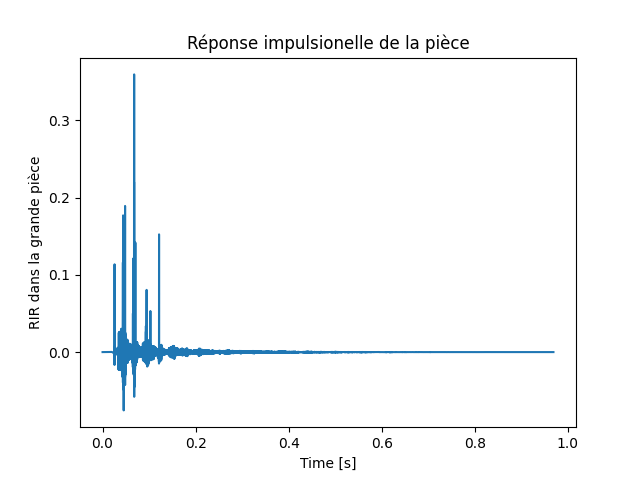

<IPython.core.display.Javascript object>


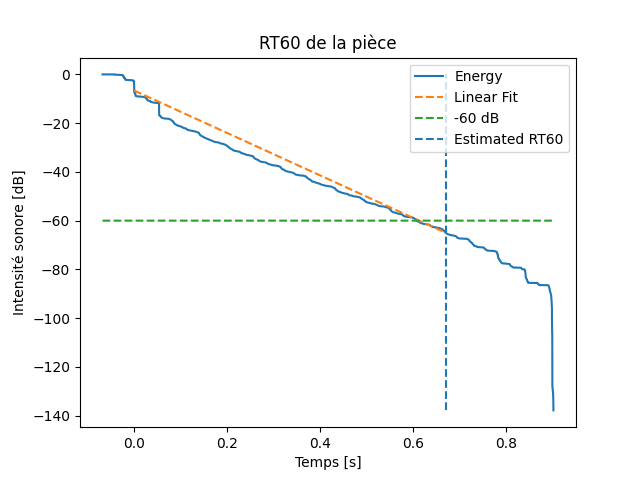

Niveau sonore du signal d'entrée =  84.28685576430313  dB
Niveau sonore du signal de sortie =  75.92479455729871  dB
Fraction de l'énergie transmise =  0.38185364422200907


<IPython.core.display.Javascript object>


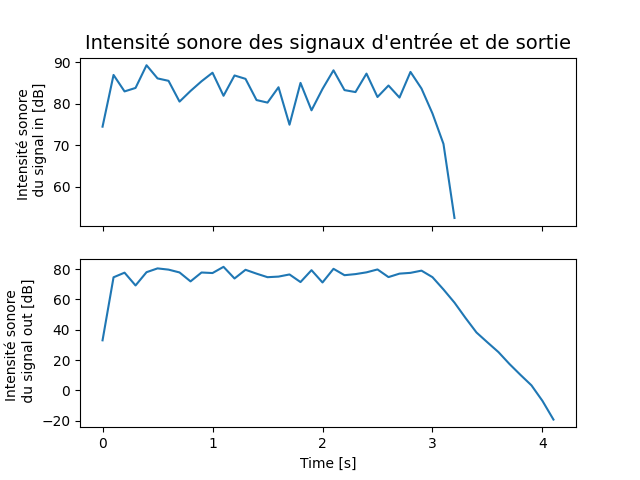

Original :


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pyroomacoustics as pra
import IPython
%matplotlib notebook

roomH = 10
roomL = 10
Lspike = 1
Hspike = 0
coordlist = []
nspikes = int(roomH/Lspike)
print(nspikes)

for i in range(nspikes):    
    Xw = -roomL/2
    Yw = i*Lspike
    Xs = Xw + Hspike
    Ys = Yw + Lspike/2
    coordw = [Xw,Yw]
    coords = [Xs,Ys]
    coordlist.append(coordw)
    coordlist.append(coords)
    if i == (nspikes-1):    
        coordlist.append([Xw,(i+1)*Lspike])
    else:
        pass


coordlist = np.array(coordlist)
coordlist2 = coordlist.copy()
for i in range(len(coordlist)):
    coordlist2[i][0] = coordlist[i][0] * -1

coordlist2 = coordlist2[::-1]
coordt = np.asarray(np.append(coordlist,coordlist2, axis = 0))


# Je commence par définir un fichier à lire (qui est dans le dossier du code) qui donne deux informations:
# le signal et la fréquence d'echantillonage
fs, signal_in = wavfile.read("arctic_a0010.wav")

# Définir la pièce avec ses materiaux
corners = coordt.T  # [x,y]
wall_absorption = 0.2
wall_scattering = 0.1
m = pra.Material(wall_absorption, wall_scattering)

# l'ordre de la simulation est définit ici
simulation_order = 4

#création de la pièce
room = pra.Room.from_corners(corners, fs=fs, max_order=simulation_order, materials=m, ray_tracing=True, air_absorption=True)
room_height = 2
room.extrude(room_height, materials=m)


# Ajouter une source et un microphone
X_source = [0, 1, 1]
room.add_source(X_source, signal=signal_in)
X_micro = np.array([[0], [9], [1]])  # [[x], [y], [z]]
room.add_microphone(X_micro)
################
fig, ax = room.plot()
ax.set_xlim([-roomL - 2, roomL + 2])
ax.set_ylim([-roomH - 2, roomH + 2]);
ax.set_zlim([0, room_height+2]);
# Ajuster les paramètres du tracer de rayon
room.set_ray_tracing(receiver_radius=2, n_rays=10000, energy_thres=1e-5)

# calcule les sources images
room.image_source_model();

# trace un schema de la situation
fig, ax = room.plot(img_order=simulation_order)
plt.title('Schema de la pièce avec les sources images')
plt.xlabel('axe 1 [m]')
plt.ylabel('axe 2 [m]')
ax.set_xlim([-roomL - 2, roomL + 2])
ax.set_ylim([-roomH - 2, roomH + 2]);
ax.set_zlim([0, room_height+2]);

# Signaux d'entree et de sortie
room.simulate()

# Cette partie sert à convertir les signaux en pression réaliste. Sinon, ces vecteurs sont uniquement des fichiers .wav.
signal_in = np.array(signal_in)/1e4
signal_out = np.array(room.mic_array.signals[0, :])/2e4

# On met en graphique les signaux d'entree et de sortie
dt = 1/fs
fig, ax = plt.subplots(2, 1, sharex=True)
timeIn = np.linspace(0, dt*(len(signal_in)), len(signal_in))
ax[0].plot(timeIn, signal_in)
ax[0].set_ylabel('Pression [Pa]')
ax[0].set_title('Signal d entrée')

timeOut = np.linspace(0, dt*(len(signal_out)), len(signal_out))
ax[1].plot(timeOut, signal_out)
ax[1].set_ylabel('Pression [Pa]')
ax[1].set_title('Signal de sortie')
ax[1].set_xlabel('Temps [s]')

# faire un graphique de la RIR
plt.figure()
signal_rir = room.rir[0][0]
time = np.linspace(0, dt*(len(signal_rir)), len(signal_rir))
plt.ylabel('RIR dans la grande pièce')
plt.plot(time, signal_rir)
plt.xlabel('Time [s]');
plt.title('Réponse impulsionelle de la pièce')

# Le RT60 est une mesure du temps de réverberation de la pièce. Il équivault au temps lorsque le son est 60dB
# de moins que l'intensité sonore maximale.
plt.figure()
plt.title('RT60 de la pièce', fontsize=12)
plt.xlabel('Temps [s]')
plt.ylabel('Intensité sonore [dB]')
rt60 = room.measure_rt60(plot=True)

####################################################
ti_in = dt*len(signal_in)
ti_out = dt*len(signal_out)

p_eff_in = np.sqrt(1/ti_in*np.trapz(signal_in**2, dx=dt))
p_eff_out = np.sqrt(1/ti_out*np.trapz(signal_out**2, dx=dt))

# print(pra.utilities.rms(signal_in))

N_in = 20*np.log10(p_eff_in/(20*10**-6))
N_out = 20*np.log10(p_eff_out/(20*10**-6))

print("Niveau sonore du signal d'entrée = ", N_in, " dB")
print("Niveau sonore du signal de sortie = ", N_out, " dB")

##############################################################

fraction = p_eff_out/p_eff_in
print("Fraction de l'énergie transmise = ", fraction)

##############################################################

ti = 0.1
n_sample = int(0.1/dt)
N_in_list = []
N_out_list = []

for i in range(len(signal_in)//n_sample):
    signal_sample = signal_in[i*n_sample:(i+1)*n_sample]
    p_eff = np.sqrt(1/ti*np.trapz(signal_sample**2, dx=dt))
    N = 20*np.log10(p_eff/(20*10**-6))
    N_in_list.append(N)
    
for i in range(len(signal_out)//n_sample):
    signal_sample = signal_out[i*n_sample:(i+1)*n_sample]
    p_eff = np.sqrt(1/ti*np.trapz(signal_sample**2, dx=dt))
    N = 20*np.log10(p_eff/(20*10**-6))
    N_out_list.append(N)

time_in = np.arange(0, ti*len(N_in_list), ti)
time_out = np.arange(0, ti*len(N_out_list), ti)

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].set_ylabel("Intensité sonore \n du signal in [dB]")
ax[0].plot(time_in, N_in_list);
ax[0].set_title("Intensité sonore des signaux d'entrée et de sortie", fontsize=14)
ax[1].set_ylabel("Intensité sonore \n du signal out [dB]")
ax[1].plot(time_out, N_out_list)
ax[1].set_xlabel('Time [s]');

# original signal
print("Original :")
IPython.display.Audio(signal_in, rate=fs)




In [13]:
print("Simulated propagation to first mic:")
IPython.display.Audio(signal_out, rate=fs)

Simulated propagation to first mic:
